In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import scipy.io as sio
from time import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("mps") # apple silicon
# device = torch.device("cpu") # cpu
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # nvidia
print(f'device: {device}')

def to_tensor(x, device=torch.device("cpu")): return torch.tensor(x, dtype=torch.float32, device=device)

device: mps


In [2]:
# # download datasets from gdrive
# import gdown
# gdown.download(id="1-5KP7_OYIvDD_QXvIr5sDihVxZx1qJCN", output='mg_data/ITER_like_equilibrium_dataset_sample.mat', quiet=False)
# gdown.download(id="1Gn_OrMzxPRkTk-i77--HiWmWZyd8i8ue", output='mg_data/ITER_like_equilibrium_dataset.mat', quiet=False)

In [3]:
SAMPLE_DS_PATH = "mg_data/ITER_like_equilibrium_dataset_sample.mat" # sample dataset
FULL_DS_PATH = 'mg_data/ITER_like_equilibrium_dataset.mat' # full dataset
MODEL_SAVE_PATH = "mg_data/mg_planet.pth"
EPOCHS = 25
BATCH_SIZE = 256
LEARNING_RATE = 1e-3
USE_CURRENTS = True
USE_PROFILES = False
USE_MAGNETIC = False
INPUT_SIZE = int(USE_CURRENTS)*14 + int(USE_PROFILES)*202 + int(USE_MAGNETIC)*187

In [4]:
class PlaNetDataset(Dataset):
    def __init__(self, ds_path):
        ds = sio.loadmat(ds_path)
        # output: magnetic flux, transposed (matlab is column-major)
        self.psi = to_tensor(ds["DB_psi_pixel_test_ConvNet"].transpose(0, 2, 1)) # (n, 64, 64)
        # inputs: radial and vertical position of pixels (for plotting only rn) + currents + measurements + profiles 
        self.rr_pix = ds["RR_pixels"] # radial position of pixels (64, 64)
        self.zz_pix = ds["ZZ_pixels"] # vertical position of pixels (64, 64)
        self.currs = ds["DB_coils_curr_test_ConvNet"] # input currents (n, 14)
        self.magn_meas = ds["DB_meas_Bpickup_test_ConvNet"] # input magnetic measurements (n, 187)
        self.f_profile = ds["DB_f_test_ConvNet"] # input profiles (n, 101)
        self.p_profile = ds["DB_p_test_ConvNet"] # input profiles (n, 101)
        inputs = []
        if USE_CURRENTS: inputs.append(to_tensor(self.currs)) # (n, 14)
        if USE_MAGNETIC: inputs.append(to_tensor(self.magn_meas)) # (n, 187)
        if USE_PROFILES: inputs.append(torch.cat((to_tensor(self.f_profile), to_tensor(self.p_profile)), 1)) # (n, 202)
        self.inputs = torch.cat(inputs, 1) # (n, 403)
    def __len__(self): return len(self.psi)
    def __getitem__(self, idx): return self.inputs[idx], self.psi[idx]

In [5]:
# test dataset
ds = PlaNetDataset(SAMPLE_DS_PATH)
print(f"Dataset length: {len(ds)}")
print(f"Input shape: {ds[0][0].shape}")
print(f"Output shape: {ds[0][1].shape}")

Dataset length: 500
Input shape: torch.Size([14])
Output shape: torch.Size([64, 64])


In [6]:
# class PlaNet(torch.nn.Module): # simple fully connected neural network > weak > loss:33 > converges to a constant
#     def __init__(self):
#         super(PlaNet, self).__init__()
#         self.n = 8
#         self.fc1 = torch.nn.Linear(INPUT_SIZE, self.n)
#         self.fc2 = torch.nn.Linear(self.n, self.n)
#         self.fc3 = torch.nn.Linear(self.n, 64*64)
#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = self.fc3(x)
#         x = x.view(-1, 64, 64)
#         return x

In [7]:
class PlaNet(torch.nn.Module): # transpose convolutional neural network > stronger, fast, but artifacts > loss:0.49
    def __init__(self):
        super(PlaNet, self).__init__()
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(INPUT_SIZE, 32),
            torch.nn.ReLU(),
            # torch.nn.BatchNorm1d(32),
            torch.nn.Linear(32, 64),
            torch.nn.ReLU(),
            # torch.nn.BatchNorm1d(64)
        )
        self.unconv = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64, 32, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2),
            torch.nn.ReLU(),
            # torch.nn.BatchNorm2d(16),
            torch.nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2),
            torch.nn.ReLU(),
            # torch.nn.BatchNorm2d(8),
            torch.nn.ConvTranspose2d(8, 4, kernel_size=3, stride=2),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(4, 1, kernel_size=4, stride=2),
        )
    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 64, 1, 1)
        x = self.unconv(x)
        x = x.view(-1, 64, 64)
        return x
# all 3       > loss:0.70
# no profiles > loss:0.48
# no magnetic > loss:0.64
# no currents > loss:33 > fail
# only currs  > loss:0.28 best

In [8]:
# class PlaNet(torch.nn.Module): # upsample convolutional neural network > slower > but smoother
#     def __init__(self):
#         super(PlaNet, self).__init__()
#         self.interp = 'bilinear' # 'nearest' or 'bilinear'
#         self.fc = torch.nn.Sequential(
#             torch.nn.Linear(INPUT_SIZE, 32),
#             torch.nn.ReLU(),
#             torch.nn.BatchNorm1d(32),
#             torch.nn.Linear(32, 64),
#             torch.nn.ReLU(),
#             torch.nn.BatchNorm1d(64)
#         )
#         self.unconv1 = torch.nn.Sequential(
#             torch.nn.Upsample(scale_factor=4, mode=self.interp),
#             torch.nn.Conv2d(64, 32, kernel_size=3, padding=1),
#             torch.nn.ReLU(),
#             torch.nn.BatchNorm2d(32),
#             torch.nn.Upsample(scale_factor=2, mode=self.interp),
#             torch.nn.Conv2d(32, 16, kernel_size=3, padding=1),
#             torch.nn.ReLU(),
#             # torch.nn.BatchNorm2d(16),
#             torch.nn.Upsample(scale_factor=2, mode=self.interp),
#             torch.nn.Conv2d(16, 8, kernel_size=3, padding=1),
#             torch.nn.ReLU(),
#             # torch.nn.BatchNorm2d(8),
#             torch.nn.Upsample(scale_factor=2, mode=self.interp),
#             torch.nn.Conv2d(8, 4, kernel_size=3, padding=1),
#             torch.nn.ReLU(),
#             torch.nn.Upsample(scale_factor=2, mode=self.interp),
#             torch.nn.Conv2d(4, 1, kernel_size=3, padding=1),
#         )
#     def forward(self, x):
#         x = self.fc(x)
#         x = x.view(-1, 64, 1, 1)
#         x = self.unconv1(x)
#         x = x.view(-1, 64, 64)
#         return x
# # all 3:            loss:0.34
# # only currents:    loss:0.44
# # no profiles:      loss:0.35

In [9]:
train_ds, val_ds = PlaNetDataset(FULL_DS_PATH), PlaNetDataset(SAMPLE_DS_PATH)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True) # initialize DataLoader
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)  
model = PlaNet()  # instantiate model
model.to(device) # move model to device
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = torch.nn.MSELoss() # Mean Squared Error Loss
best_loss = float('inf') # initialize best loss
for epoch in range(EPOCHS): 
    epoch_time = time()
    model.train()
    trainloss, evalloss = [], []
    # for input_currs, psi in tqdm(train_dl, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False):
    for input_currs, psi in train_dl:
        input_currs, psi = input_currs.to(device), psi.to(device) # move to device
        optimizer.zero_grad()
        psi_pred = model(input_currs)
        loss = loss_fn(psi_pred, psi)
        loss.backward()
        optimizer.step()
        trainloss.append(loss.item())
    model.eval()
    with torch.no_grad():
        for input_currs, psi in val_dl:
            input_currs, psi = input_currs.to(device), psi.to(device) # move to device
            psi_pred = model(input_currs)
            loss = loss_fn(psi_pred, psi)
            evalloss.append(loss.item())
    print(f"Ep {epoch+1}: Train Loss: {sum(trainloss)/len(trainloss):.4f}, Eval Loss: {sum(evalloss)/len(evalloss):.4f}, Time: {time()-epoch_time:.2f}s,", end=" ")
    if sum(evalloss)/len(evalloss) < best_loss:
        best_loss = sum(evalloss)/len(evalloss)
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print("new best")
    else: print()

Ep 1: Train Loss: 16.7279, Eval Loss: 2.9102, Time: 7.62s, new best
Ep 2: Train Loss: 2.3240, Eval Loss: 1.6390, Time: 6.26s, new best
Ep 3: Train Loss: 1.5869, Eval Loss: 1.1737, Time: 6.63s, new best
Ep 4: Train Loss: 1.2806, Eval Loss: 0.9624, Time: 6.17s, new best
Ep 5: Train Loss: 1.1104, Eval Loss: 0.8197, Time: 6.32s, new best
Ep 6: Train Loss: 0.9703, Eval Loss: 0.7302, Time: 6.45s, new best


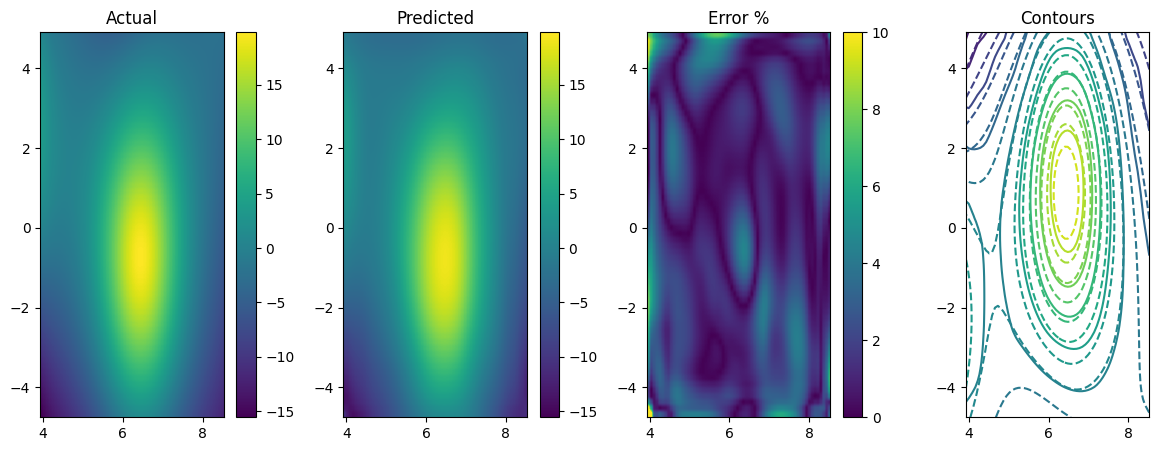

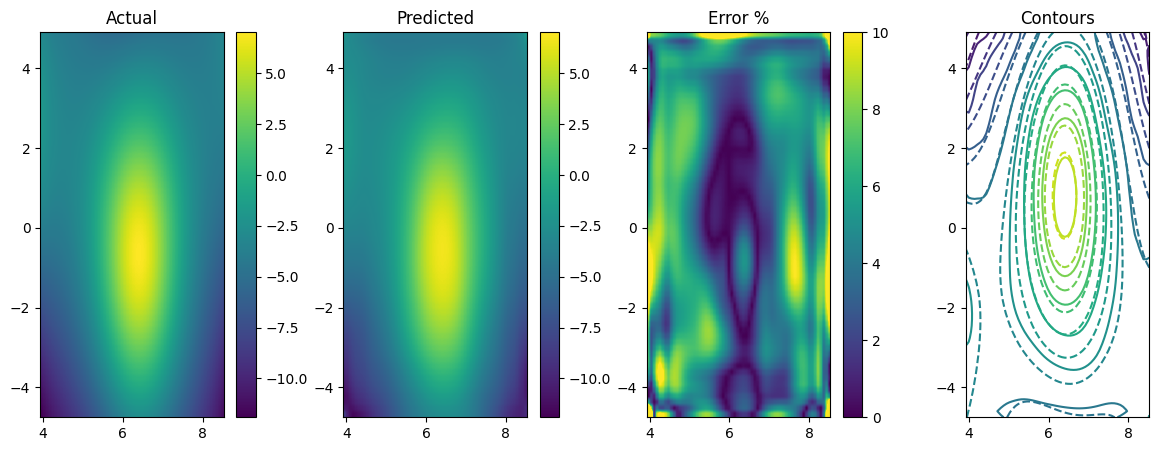

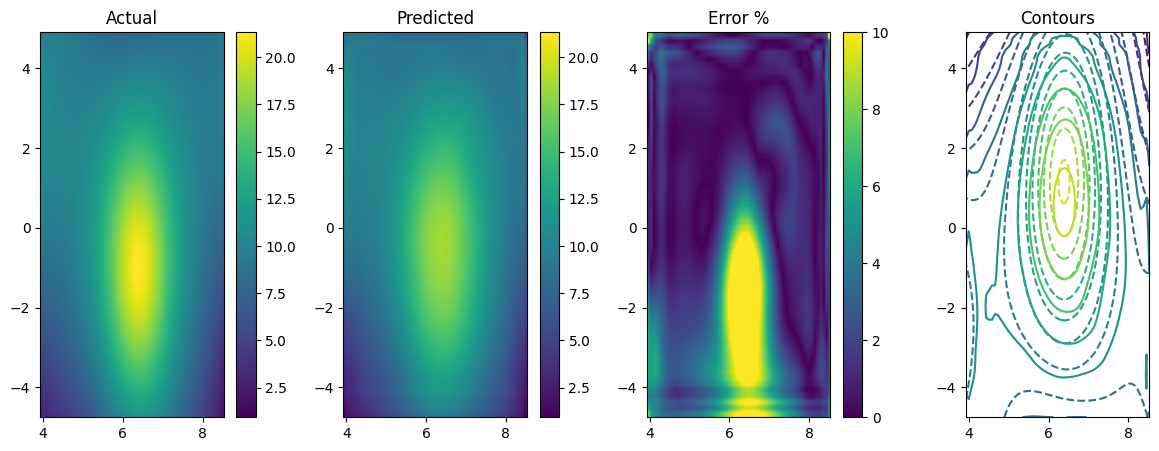

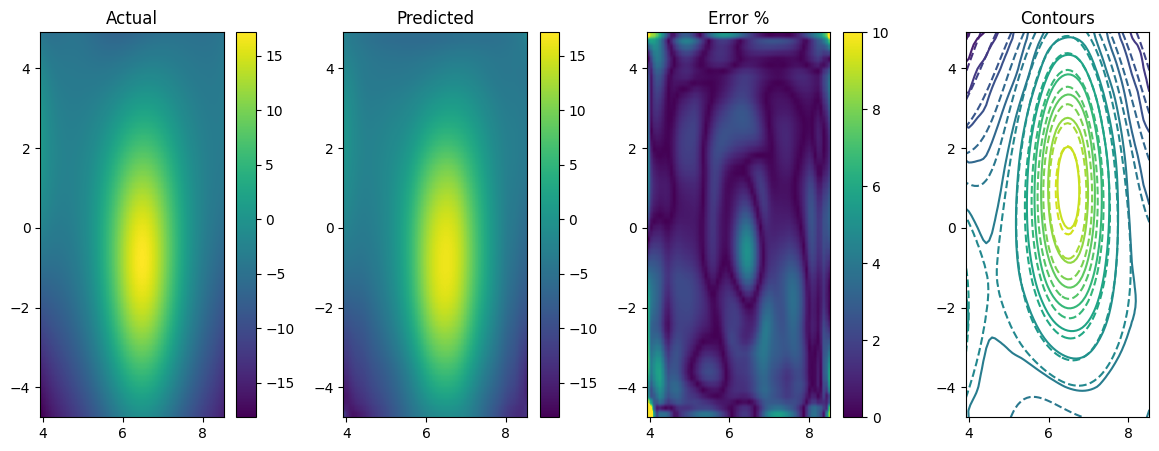

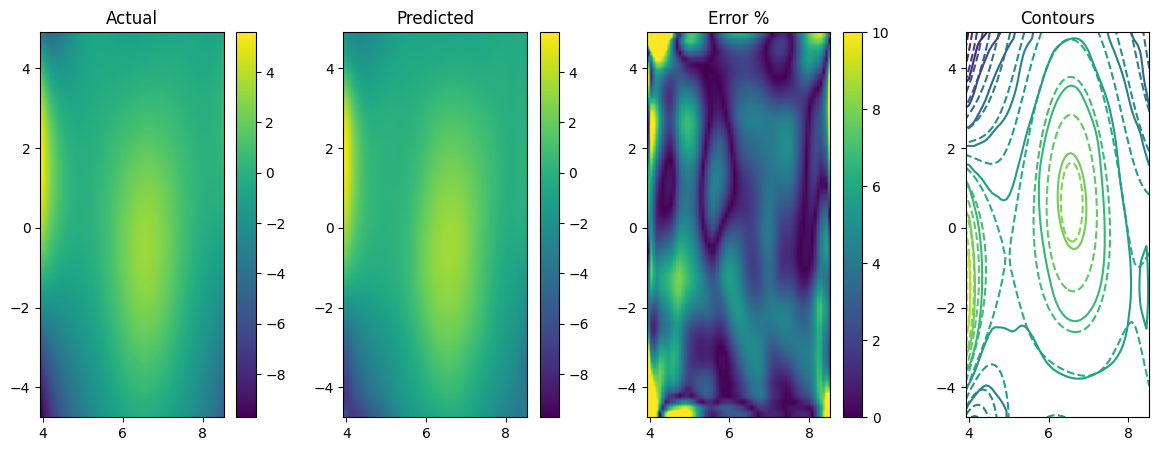

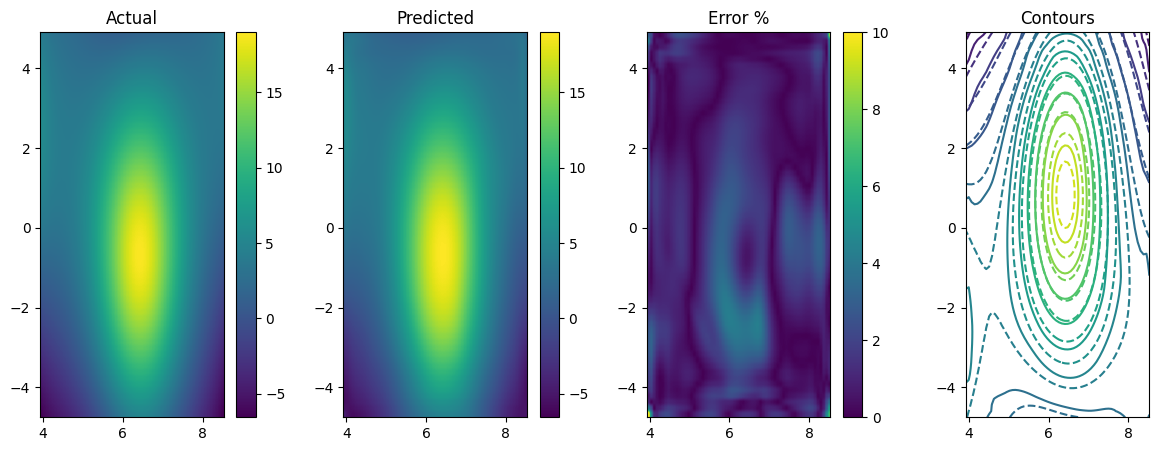

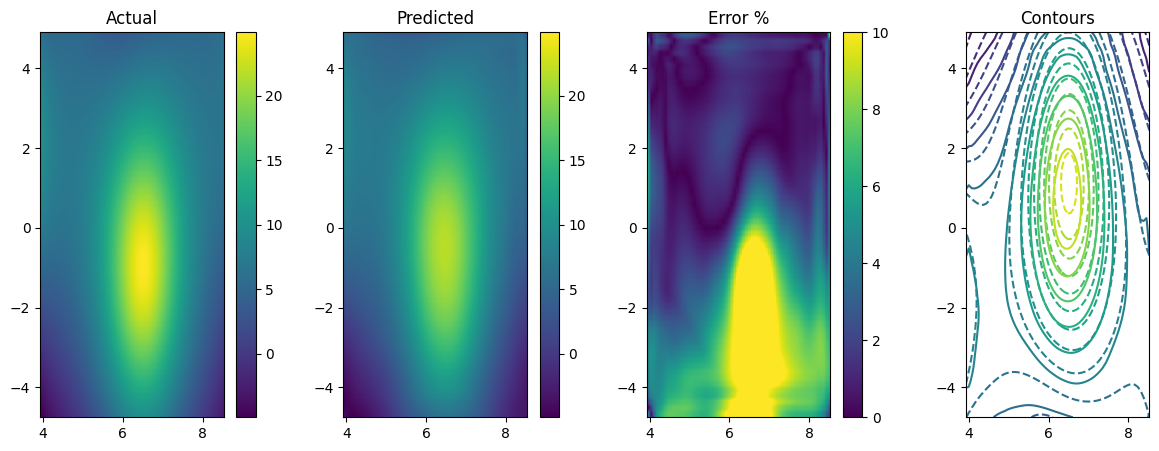

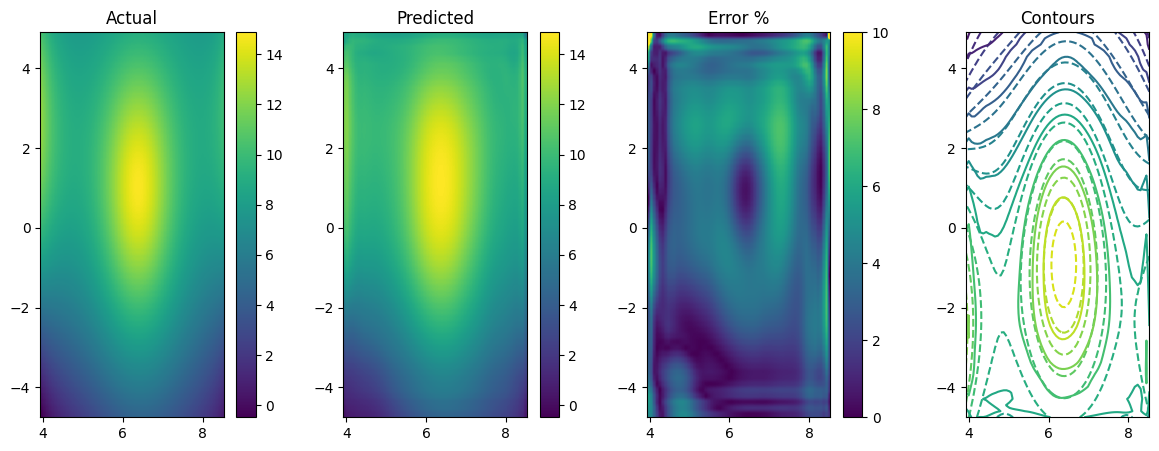

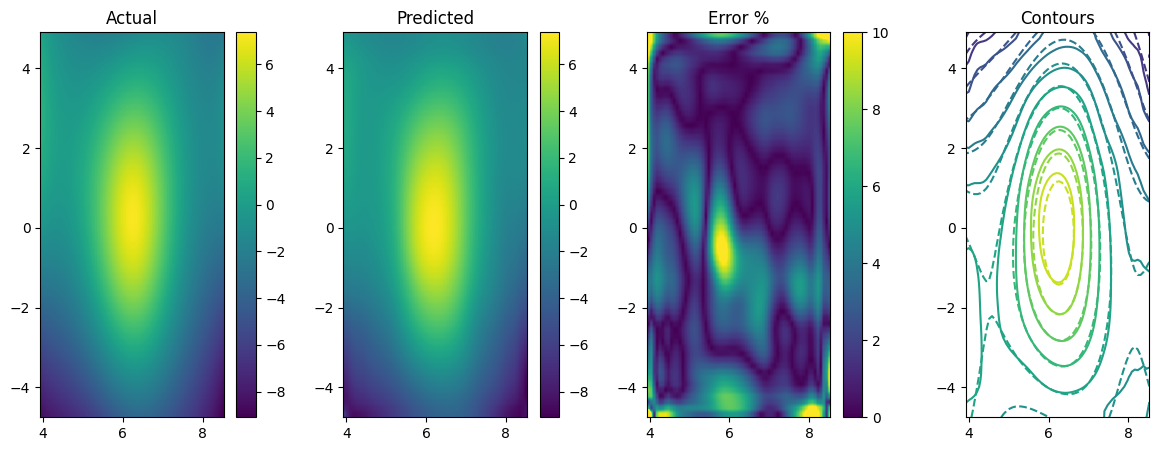

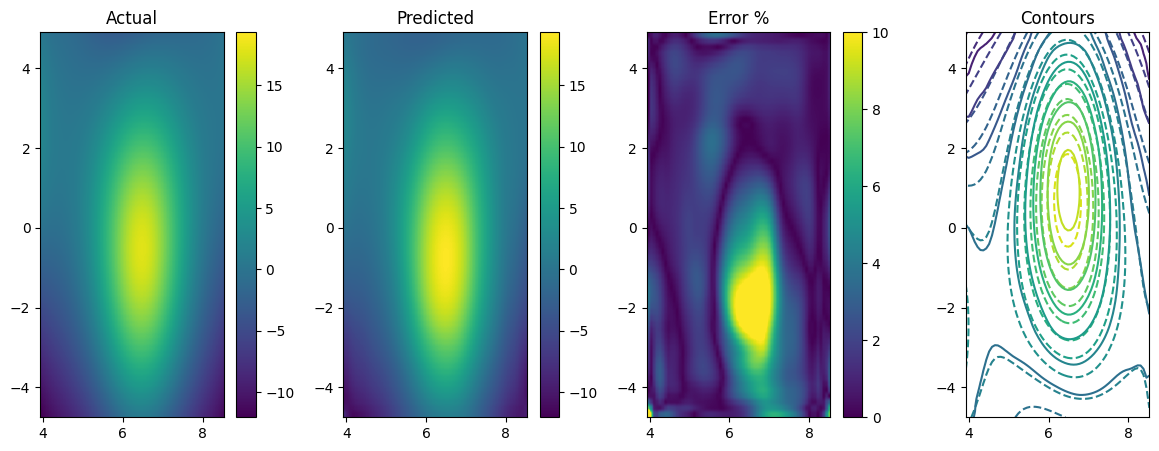

In [20]:
model = PlaNet()
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
model.eval()
ds = PlaNetDataset(SAMPLE_DS_PATH)
for i in np.random.randint(0, len(ds), 10):  
    input_currs, psi = ds[i]
    psi_pred = model(input_currs.unsqueeze(0))
    psi_pred = psi_pred.detach().numpy().reshape(64, 64)
    psi = psi.detach().numpy().reshape(64, 64)
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))
    ext = [ds.rr_pix.min(), ds.rr_pix.max(), ds.zz_pix.min(), ds.zz_pix.max()]
    rr, zz = ds.rr_pix, ds.zz_pix  # radial and vertical positions of pixels
    bmin, bmax = np.min([psi, psi_pred]), np.max([psi, psi_pred])
    err = np.abs(psi - psi_pred)*100/abs(bmax)

    im0 = axs[0].imshow(psi, extent=ext, vmin=bmin, vmax=bmax)
    axs[0].set_title("Actual")
    axs[0].set_aspect('equal')
    fig.colorbar(im0, ax=axs[0]) 

    im1 = axs[1].imshow(psi_pred, extent=ext, vmin=bmin, vmax=bmax)
    axs[1].set_title("Predicted")
    axs[1].set_aspect('equal')
    fig.colorbar(im1, ax=axs[1])

    im2 = axs[2].imshow(err, extent=ext, vmin=0, vmax=10)
    axs[2].set_title("Error %")
    axs[2].set_aspect('equal')
    fig.colorbar(im2, ax=axs[2])

    c0 = axs[3].contour(rr, zz, psi, levels=15, cmap='viridis', linestyles='dashed')
    c1 = axs[3].contour(rr, zz, psi_pred, levels=10, cmap='viridis')
    axs[3].set_title("Contours")
    axs[3].set_aspect('equal')

    plt.show()